<a href="https://colab.research.google.com/github/yukinaga/image_classification/blob/main/section_2/03_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 演習
今回の演習では、CNNの実装を練習します。  
新たなデータ拡張の追加、およびCNNモデルの構築のコードを記述してください。

## データの前処理
以下のセルにコードを追記し、データ拡張に'transforms.RandomErasing()'によるランダムな画像領域の消去を追加しましょう。

In [13]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine((-10, 10), scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.2) # ← ここにコードを追記

transform_train = transforms.Compose([affine, flip, to_tensor, erase, normalize])  # ←ここにコードを追記
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
以下のセルで、forwardメソッドの内部にコードを記述して、CNNのモデルを構築しましょう。

In [14]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数, フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # ------- 以下にコードを書く -------
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        # ------- ここまで -------
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習


In [15]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8120473187292934 Loss_Test: 1.578598769607058
Epoch: 1 Loss_Train: 1.5897349349373138 Loss_Test: 1.4296339636395692
Epoch: 2 Loss_Train: 1.5218984030396736 Loss_Test: 1.4036248960312765
Epoch: 3 Loss_Train: 1.4824423360092867 Loss_Test: 1.3850255202335917
Epoch: 4 Loss_Train: 1.4565600672036485 Loss_Test: 1.3352329882846516
Epoch: 5 Loss_Train: 1.4340115992919258 Loss_Test: 1.293325023666309
Epoch: 6 Loss_Train: 1.411571829901327 Loss_Test: 1.2964755915532447
Epoch: 7 Loss_Train: 1.4007898768805482 Loss_Test: 1.2488895897652692
Epoch: 8 Loss_Train: 1.3832834230359559 Loss_Test: 1.2381937670859562
Epoch: 9 Loss_Train: 1.3736065598704932 Loss_Test: 1.2486350942569173
Epoch: 10 Loss_Train: 1.364380823529285 Loss_Test: 1.2483707708158311
Epoch: 11 Loss_Train: 1.3617315865538615 Loss_Test: 1.2569618938834803
Epoch: 12 Loss_Train: 1.3541017129750508 Loss_Test: 1.2910415093610241
Epoch: 13 Loss_Train: 1.3500229615689543 Loss_Test: 1.2444178055805766
Epoch: 14 Loss_Train

## 誤差の推移

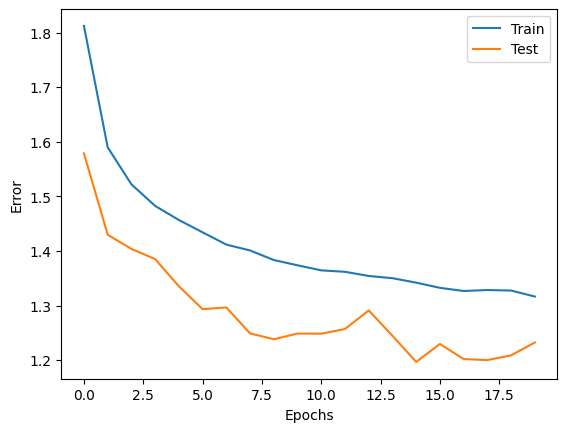

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率

In [17]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 56.24%


## 訓練済みのモデルを使った予測

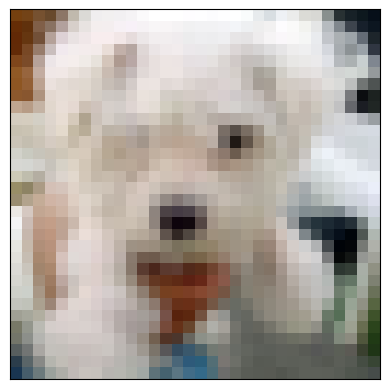

正解: dog 予測結果: deer


In [29]:
cifar10_classes = ["airplane", "automobile", "bird",
                   "cat", "deer", "dog", "frog",
                   "horse", "ship", "truck"]

cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter)  # サンプルを1つだけ取り出す

plt.imshow(images[0].permute(1, 2, 0))  # 一番後の次元をチャンネルに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])

# 解答例
以下は解答例です。

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()
erase = transforms.RandomErasing(p=0.5)  # ← ここにコードを追記

transform_train = transforms.Compose([affine, flip, to_tensor, normalize, erase])  # ←ここにコードを追記
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数, フィルタサイズ)
        self.relu = nn.ReLU()  # ReLU
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, 領域の間隔）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # ------- 以下にコードを書く -------
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16*5*5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # ------- ここまで -------
        return x

net = Net()
net.cuda()  # GPU対応
print(net)